# This notebook demonstrates self-distillation of a Denoising Diffusion transformer model

# Imports

In [3]:
from util_DiT import *
import os
%reload_ext autoreload
%autoreload 2
import torch
from torchvision.utils import save_image
from diffusion import create_diffusion
from diffusers.models import AutoencoderKL
from download import find_model
from models import DiT_XL_2
from PIL import Image
from IPython.display import display
torch.set_grad_enabled(False)
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu":
    print("GPU not found. Using CPU instead.")

cwd = os.getcwd()

c:\ProgramData\Anaconda3\envs\thesis\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


# Creating Model

In [4]:
# Setting up image sizes
image_size = 256 #@param [256, 512]
vae_model = "stabilityai/sd-vae-ft-ema" #@param ["stabilityai/sd-vae-ft-mse", "stabilityai/sd-vae-ft-ema"]
latent_size = int(image_size) // 8

# Load model:
model = DiT_XL_2(input_size=latent_size).to(device)
state_dict = find_model(f"DiT-XL-2-{image_size}x{image_size}.pt")
model.load_state_dict(state_dict)
model.eval() # important!
vae = AutoencoderKL.from_pretrained(vae_model).to(device)

# Doing a single denoising step

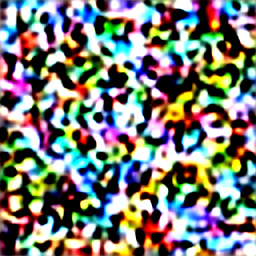

In [5]:
n = 1
num_sampling_steps = 5 #@param {type:"slider", min:0, max:1000, step:1}
cfg_scale = 4 #@param {type:"slider", min:1, max:10, step:0.1}
class_labels = [207]
samples_per_row = 4 #@param {type:"number"}

# Create diffusion object:
diffusion = create_diffusion(str(num_sampling_steps))
# Sample inputs:
z = torch.randn(1, model.in_channels, latent_size, latent_size, device=device)
y = torch.randint(0, 1, (n,), device=device)

# Setup classifier-free guidance:

z = torch.cat([z, z], 0)
y_null = torch.tensor([1000] * n, device=device)
y = torch.cat([y, y_null], 0)
model_kwargs = dict(y=y, cfg_scale=4)
sample_fn = model.forward_with_cfg


# Sample images:
samples = diffusion.ddim_sample_loop_progressive_grad(
    sample_fn, z.shape, z, clip_denoised=False, model_kwargs=model_kwargs, progress=False, device=device
)

samples, _ = samples.chunk(2, dim=0)  # Remove null class samples

samples = vae.decode(samples / 0.18215).sample
save_image(samples, "sample.png", nrow=int(samples_per_row), 
           normalize=True, value_range=(-1, 1))
samples = Image.open("sample.png")
display(samples)


# Distillation Loop

In [1]:
from util_DiT import *
import os
%reload_ext autoreload
%autoreload 2
import torch
from torchvision.utils import save_image
from diffusion import create_diffusion
from diffusers.models import AutoencoderKL
from download import find_model
from models import DiT_XL_2
from PIL import Image
from IPython.display import display
torch.set_grad_enabled(True)
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cuda"
if device == "cpu":
    print("GPU not found. Using CPU instead.")

cwd = os.getcwd()
# Setting up image sizes
image_size = 256 #@param [256, 512]
vae_model = "stabilityai/sd-vae-ft-ema" #@param ["stabilityai/sd-vae-ft-mse", "stabilityai/sd-vae-ft-ema"]
latent_size = int(image_size) // 8

# Load model:
model = DiT_XL_2(input_size=latent_size).to(device)
state_dict = find_model(f"DiT-XL-2-{image_size}x{image_size}.pt")
model.load_state_dict(state_dict)
model.eval() # important!
vae = AutoencoderKL.from_pretrained(vae_model).to("cpu")
del state_dict, vae_model
torch.cuda.empty_cache()
steps = 20
generations = 10
decrease_steps = False

# !set 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:128'

c:\ProgramData\Anaconda3\envs\thesis\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


In [2]:
%reload_ext autoreload
%autoreload 2




model = model
steps = steps
NUM_CLASSES = 1000
cfg_scale = 4
generations = generations
halvings = math.floor(math.log(steps)/math.log(2)) - 1
halving_steps = []
for i in range(1, halvings+1):
    halving_steps.append(int(generations * (1 / (halvings + 2)) * i))

intermediate_generation_compare = int(generations * 0.8 / (halvings + 1))

criterion = nn.MSELoss()
optimizer, scheduler = get_optimizer(model, iterations=steps*generations)

updates = int(steps / 2)

instance = 0
generation = 0
all_losses = []
averaged_losses = []
# diffusion = create_diffusion(str(steps))


samples_per_row = 1


with tqdm.tqdm(torch.randint(0, NUM_CLASSES, (generations,))) as tepoch:
    for i, class_prompt in enumerate(tepoch):
        # if i in halving_steps and decrease_steps==True:
        #     steps = int(steps / 2)
        #     updates = int(steps / 2)
        #     diffusion = create_diffusion(str(steps))
        #     print("halved:", steps)
        diffusion = create_diffusion(str(steps))
        generation += 1
        losses = []        
        predictions_temp = []
        

        z = torch.randn(1, model.in_channels, latent_size, latent_size, device=device)

        y = torch.tensor([class_prompt], device=device)

        z = torch.cat([z, z], 0)

        y_null = torch.tensor([1000] * 1, device=device)

        y = torch.cat([y, y_null], 0)

        model_kwargs = dict(y=y, cfg_scale=4)

        
        timesteps =  list(range(diffusion.num_timesteps))[::-1]
        print(timesteps)

        samples = torch.randn(*z.shape, device=device)
        
        

        print("updates:", updates)
        for step in range(updates):
            
            print(torch.cuda.memory_allocated())
            instance += 1
            print(step, end="-")
            losses, samples = internal_distill_loop(diffusion, model_kwargs, timesteps, 
                          optimizer, step, criterion, scheduler, losses, model, samples)
            # with torch.enable_grad():
            #     optimizer.zero_grad()
                
            #     samples, pred_xstart = sample_step_grad(sample_fn, diffusion, step, model_kwargs, timesteps, samples)
            #     samples.detach()
            #     with torch.no_grad():
            #         samples, pred_xstart_second = sample_step(sample_fn, diffusion, step, model_kwargs, timesteps, samples)
                    
            #     with torch.enable_grad():
            #         loss = criterion(pred_xstart, pred_xstart_second.detach())
            #         loss.backward()
            #         torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            #         optimizer.step()
            #         scheduler.step()
            #         losses.append(loss.item())
            
  
                    


  0%|          | 0/10 [00:00<?, ?it/s]

[19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]
updates: 10
2724964864
0-t: tensor([19, 19], device='cuda:0') p_mean_variance T: tensor([19, 19], device='cuda:0')
t: tensor([19, 19], device='cuda:0') 5447741952
1-t: tensor([18, 18], device='cuda:0') p_mean_variance T: tensor([18, 18], device='cuda:0')
t: tensor([18, 18], device='cuda:0') 5447741952
2-t: tensor([17, 17], device='cuda:0') p_mean_variance T: tensor([17, 17], device='cuda:0')
t: tensor([17, 17], device='cuda:0') 5447741952
3-t: tensor([16, 16], device='cuda:0') p_mean_variance T: tensor([16, 16], device='cuda:0')
t: tensor([16, 16], device='cuda:0') 5447741952
4-t: tensor([15, 15], device='cuda:0') p_mean_variance T: tensor([15, 15], device='cuda:0')
t: tensor([15, 15], device='cuda:0') 5447741952
5-t: tensor([14, 14], device='cuda:0') p_mean_variance T: tensor([14, 14], device='cuda:0')
t: tensor([14, 14], device='cuda:0') 5447741952
6-t: tensor([13, 13], device='cuda:0') p_mean_variance T: tensor([

 10%|█         | 1/10 [00:05<00:48,  5.40s/it]

[19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]
updates: 10
5447741952
0-t: tensor([19, 19], device='cuda:0') p_mean_variance T: tensor([19, 19], device='cuda:0')
t: tensor([19, 19], device='cuda:0') 5447741952
1-t: tensor([18, 18], device='cuda:0') p_mean_variance T: tensor([18, 18], device='cuda:0')
t: tensor([18, 18], device='cuda:0') 5447741952
2-t: tensor([17, 17], device='cuda:0') p_mean_variance T: tensor([17, 17], device='cuda:0')
t: tensor([17, 17], device='cuda:0') 5447741952
3-t: tensor([16, 16], device='cuda:0') p_mean_variance T: tensor([16, 16], device='cuda:0')
t: tensor([16, 16], device='cuda:0') 5447741952
4-t: tensor([15, 15], device='cuda:0') p_mean_variance T: tensor([15, 15], device='cuda:0')
t: tensor([15, 15], device='cuda:0') 10895718912
5-t: tensor([14, 14], device='cuda:0') 

 10%|█         | 1/10 [00:08<01:17,  8.59s/it]


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 12.00 GiB total capacity; 10.71 GiB already allocated; 0 bytes free; 11.28 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

11498027520


AttributeError: 'function' object has no attribute 'requires_grad'

In [ ]:
samples, _ = samples.chunk(2, dim=0)  # Remove null class samples
samples = vae.decode(samples / 0.18215).sample

# Save and display images:
save_image(samples, "sample.png", nrow=int(samples_per_row), 
           normalize=True, value_range=(-1, 1))
samples = Image.open("sample.png")
display(samples)

In [ ]:
steps

10

In [ ]:
updates

5

In [ ]:
# samples, _ = samples.chunk(2, dim=0)
# samples = vae.decode(samples / 0.18215).sample
# save_image(samples, "sample.png", nrow=int(samples_per_row), 
#            normalize=True, value_range=(-1, 1))
# samples = Image.open("sample.png")
# display(samples)